In [1]:
!pip install kagglehub


In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mujadilhazqeel","key":"d2b49d0d9a8ef91b34b088e007308086"}'}

In [3]:
# Move kaggle.json to the ~/.kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
import kagglehub

# Download the dataset
eye_diseases_classification_path = kagglehub.dataset_download('gunavenkatdoddi/eye-diseases-classification')
print("Dataset downloaded to:", eye_diseases_classification_path)


100%|██████████| 736M/736M [00:05<00:00, 141MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [5]:
!ls {eye_diseases_classification_path}


dataset


In [6]:
path="/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset"

In [7]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models

In [8]:
# Load and preprocess dataset
classes = os.listdir(path)
print("Classes found:", classes)

for c in classes:
    c_path = os.path.join(path, c)
    if os.path.isdir(c_path):
        print(c, ":", len(os.listdir(c_path)), "images")



Classes found: ['normal', 'glaucoma', 'cataract', 'diabetic_retinopathy']
normal : 1074 images
glaucoma : 1007 images
cataract : 1038 images
diabetic_retinopathy : 1098 images


In [9]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Class names
class_names = train_ds.class_names
print("Class names:", class_names)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [10]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.5297 - loss: 1.1297 - val_accuracy: 0.7248 - val_loss: 0.6554
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7417 - loss: 0.6292 - val_accuracy: 0.7604 - val_loss: 0.5580
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.7804 - loss: 0.5244 - val_accuracy: 0.7972 - val_loss: 0.4949
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.8021 - loss: 0.4601 - val_accuracy: 0.8007 - val_loss: 0.5092
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8176 - loss: 0.4463 - val_accuracy: 0.8078 - val_loss: 0.5344
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8301 - loss: 0.4044 - val_accuracy: 0.8066 - val_loss: 0.5266
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.8406 - loss: 0.3915 - val_accuracy: 0.8256 - val_loss: 0.4439
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.8631 - loss: 0

In [13]:
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Save the model
model.save("eye_disease_classifier.h5")

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8288 - loss: 0.4727


Validation Loss: 0.4780433475971222
Validation Accuracy: 0.8268089890480042


In [14]:
import matplotlib.pyplot as plt
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


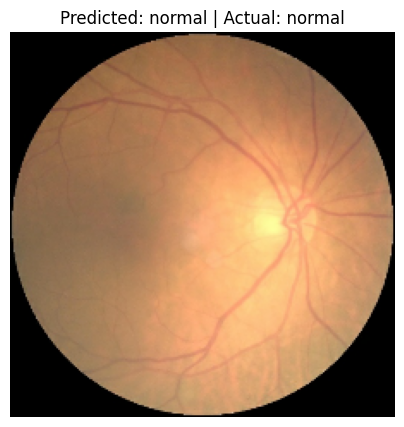

In [15]:
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    i = random.randint(0, len(images) - 1)
    plt.figure(figsize=(5, 5))
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {class_names[tf.argmax(predictions[i])]} | Actual: {class_names[labels[i]]}")
    plt.axis("off")
    plt.show()


In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import random
from PIL import Image
import os

app = Flask(__name__)

# Load the trained model
MODEL_PATH = "eye_disease_classifier.h5"
model = load_model(MODEL_PATH)

# Define class names (ensure this matches your training classes)
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']



@app.route('/')
def home():
    return "Eye Disease Classification API is running!"

@app.route('/predict-random', methods=['GET'])
def predict_random():
    """Randomly selects an image from the dataset, predicts, and returns the result."""
    try:
        # Get a random image from the dataset
        random_class = random.choice(os.listdir(path))
        class_path = os.path.join(path, random_class)
        random_image_file = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image_file)

        # Load and preprocess the image
        img = Image.open(image_path).resize((224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize

        # Predict
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = np.max(predictions[0])

        return jsonify({
            "image_path": image_path,
            "predicted_class": predicted_class,
            "confidence": float(confidence)
        })

    except Exception as e:
        return jsonify({"error": str(e)})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
